# PSTAT 134 Final Project: The Yelp Dataset

## 1 Introduction

### 1.1 Preparing the Environment

In [151]:
# system
import json
import os
import cv2
import shutil
import imutils
from imutils import paths
# basics
import numpy as np
import random
import pandas as pd
from pandas.io.json import json_normalize
# data visualization
import pydot
import pydotplus
import graphviz
from IPython.display import display
# image processing
import matplotlib.image as mpimg
from PIL import Image
import pydot
%pylab inline
# modeling
from sklearn.model_selection import train_test_split
# keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
from keras.utils import to_categorical

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1.2 Downloading the Data

The very first step of any data science project is obtaining the data. In order to obtain the data that we would like to use, the dataset provided by Yelp for analysis purposes, we access the Kaggle API. The first step is to install the Kaggle API via terminal.

In [ ]:
# install kaggle API
!pip install kaggle

Next, we make sure that the API access credentials are in the correct folder so that the system knows where to find them.

In [ ]:
# previously created kaggle API key in order to access datasets, yields kaggle.json
# make sure kaggle.json is in users/#name#/.kaggle

In [ ]:
# make API key not readable to other users
# !chmod 600 /Users/#name#/.kaggle/kaggle.json

Now that we have accessed the API, we download the yelp dataset, direct it to the preferred path, and unzip the large files simultaneously.

In [ ]:
# download and unzip the yelp-dataset kaggle files
# !kaggle datasets download yelp-dataset/yelp-dataset -p #path# --unzip

Since the photos provided by Yelp are not accessible via the Kaggle API, they were manually downloaded via the Yelp dataset website.

### 1.3 Loading the Reviews

The files come in `.json` format, so we read them into a list.

In [ ]:
# read json reviews file
reviews = []
with open('yelp_academic_dataset_review.json') as json_review:
    for line in json_review:
        reviews.append(json.loads(line))

We use `<json_normalize>` to normalize our semi-structured JSON data into a flat table.

In [ ]:
reviews = json_normalize(reviews)    

Let's take a look at the dataset format:

In [ ]:
reviews.head()

## 2 Exploratory Data Analysis

## 3 Text Mining

## 4 Convolutional Neural Network Image Classification

This part of the project consists of building a convolutional neural network that is able to classify the contents of an image as either the **outside of a business** or **food** using photos provided by the Yelp dataset. We have 1,172 images of food and 1,001 images of the outside of businesses.

  <tr>
    <td> <img src="projdata/train/food/OvyQG_yKe-GEXgX7l5_E4A.jpg"  style="width: 250px;"/> </td>
    <td> <img src="projdata/train/outside/fLmjhrhcpTNRAgXJYf5sPA.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="projdata/train/food/TVJeFR790-y5IfZ6v4i27w.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="projdata/train/outside/0yWyHteR5U7hOBoYpm23kg.jpg" alt="Drawing" style="width: 250px;"/> </td>
    </tr>

### 4.1 Introduction and Purpose

We now build an image classification model using the Keras API. Keras is a high-level neural networks and deep learning library available in Python. Since neural networks are a very in-depth and complicated concept, we try to err on the side of caution and ensure that we understand every function and idea that we implement in the network.

As a broad and simple overview of neural networks, it is composed of layers of artifical neurons which receive input, alter their function according to that input, then produce output depending on that input and alterations. This output is connected to the input of another neuron. Based on the alterations the neurons make and the weights created by the inputs, the network can learn from previous observations. This involves the incorporation of a cost function which measures how far away a particular solution is from an optimal solutio. The goal is then to find the function which minimizes that cost.

Deep neural networks have multiple layers between the input and output layers. Convolutional neural networks are a class of fully-connected, deep neural networks. This means that each neuron in one layer is connected to all neurons in the next layer. CNNs avoid overfitting by using regularization methods such as adding weights to the loss function. CNNs are on the lower extreme on the scale of connectedness and complexity and are most commonly applied to analyzing visual imagery.

The purpose of building a network that is able to tell you what is in an image it is given may not be obvious. However, image classification is becoming increasingly common and utilized by many companies. Facebook uses facial recognition to see who is in a photo to suggest tags, the healthcare industry uses computer visison to perform microsurgical procedures, and the retail industry uses image recognition to compare quality and prices of different products. Though this particular image classification project is quite simple relative to other networks, it is a first step in exposure to the complex field of neural networks. An image classification program is of great use to many industries, and a fascinating part of data science.

### 4.2 Data Augmentation

In order to make the most of the training examples and provide the model with as much predictive power as possible, we "augment" them by using random transformations. This ensures that the model never sees the exact same picture twice and also helps prevent overfitting by improving generalizability. We want our network to be invariant, meaning it can robustly classify objects even if they are placed in different orientations. The function used generates batches of tensor image data with real-time data augmentation. 

As an example, we define a data generator:

In [2]:
# data augmentation
# enabling us to generate “additional” training data by randomly transforming the input images
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

Using this data generator, we will transform one picture from the list of training images using the specified transformations. This code creates about forty versions of the original photo.

In [102]:
x = Image.open('projdata/train/food/-QqLtR0ei-kc29dwAFC2Tg.jpg')
x = img_to_array(x)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)
# perform transformations
i=0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='data_augs', save_prefix='DAex', save_format='jpeg'):
    i += 1
    if i > 20:
        # prevent infinite loop
        break
# open images that were just created
DApics = []
for i in os.listdir('data_augs'):
    if os.path.isfile(os.path.join('data_augs',i)) and 'DAex' in i:
        DApics.append(Image.open('data_augs'+'/'+i))

Now that we have created and opened these transformed images, we can plot them to see how they differ from one another.

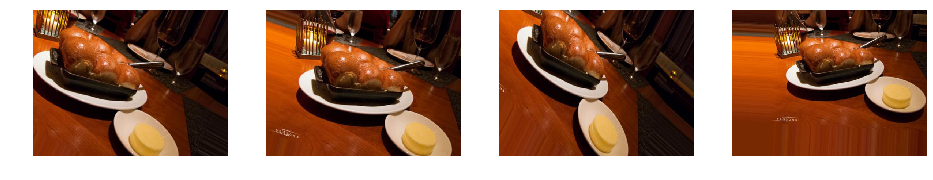

In [103]:
fig = plt.figure(figsize=(16,16))
image1 = plt.subplot(141)
image2 = plt.subplot(142)
image3 = plt.subplot(143)
image4 = plt.subplot(144)
_ = image1.imshow(DApics[0])
_ = image2.imshow(DApics[1])
_ = image3.imshow(DApics[2])
_ = image4.imshow(DApics[3])
image1.axis("off")
image2.axis("off")
image3.axis("off")
image4.axis("off")
plt.show()

As we can see, the images clearly originate from the same photo, but are characterized by a variety of length and width shifts, flips, and stretches. We can now increase the amount of relevant information that the network will use to classify these images.

### 4.3 LeNet

In order to perform the image classification, we use a class of convolutional neural networks called **LeNet**. This architecture of CNNs is relatively small and simple. LeNet is not as resource- and memory-intensive as other networks, and is an appropriate first step in building deep neural networks.

To build this model, we use four different kinds of layers:
* **Conv2D** (Convolutional layer): Applies specified number of convolution filters to the image; moves around the image, subregion by subregion, performing a mathematical operation to produce a single value for that subregion in the output (like dot-product).
* **Activation**: How each artificial neuron changes its internal state after receiving input, providing a smooth transition as input values change. We first use the rectifier activation function, which basically changes all negative values to 0. The final activation function used is the softmax function which takes in a vector of real numbers and normalizes it into a probability distribution.
* **MaxPooling2D**: Applies a filter of size 2x2 and strides of same length to the input volume and outputs the maximum number in every subregion that the filter convolves around.
* **Flatten**: Flattens features into a single column.
* **Dense**: Performs a linear operation in which every input is connected to every output by a weight (fully-connected).

As we can see, the entire network is basically a amalgamation of several functions aiming to optimize the relationship between the input and output.

In [109]:
def build(height, width, depth):
    # height, width, and depth are the pixels and channels of the image
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
        
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))
 
    # softmax classifier
    model.add(Dense(2))
    model.add(Activation("softmax"))
 
    # return the constructed network architecture
    return model

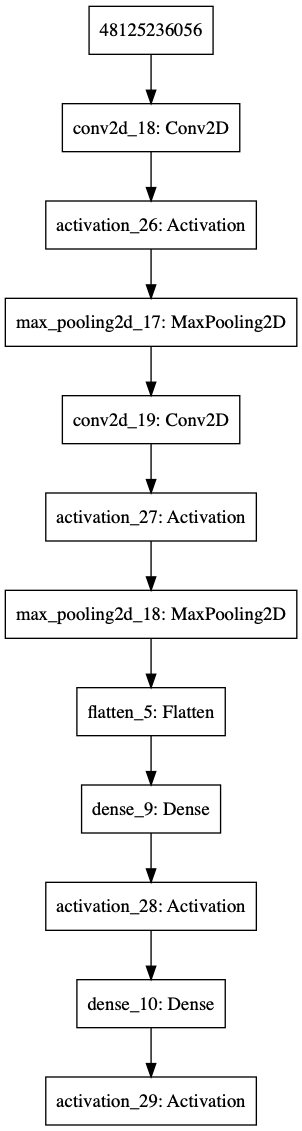

In [182]:
plot_model(model, to_file='layers.png')
layer_plot = Image.open('layers.png')
layer_plot

Now that we have a function which builds the network for us, we initialize some parameters and variables for training and assembling the data.

In [123]:
# initialize training parameters
epochs = 25 # number of times network runs through data
init_learn_rate = 1e-3 # speed at which the network learns the problem
batch_size = 32 # number of samples propagated through the network
 
# define the image and label lists
images = []
labels = []
 
# pull the image paths and randomly shuffle them
imgPaths = sorted(list(imutils.paths.list_images('projdata/train')))
random.seed(111)
random.shuffle(imgPaths)

In the following loop, we read in the image, resize it to 28 x 28 pixels, and create its category label of either *food* or *outside* based on its path name.

In [124]:
# looping over the input images
for imgPath in imgPaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imgPath)
    image = cv2.resize(image, (28, 28)) # every image is 28x28 pixels
    image = img_to_array(image) # turn image into numeric array
    images.append(image)
    # create labels from pathname, add to list
    label = imgPath.split(os.path.sep)[-2]
    label = 1 if label == "food" else 0
    labels.append(label)

Next, we preprocess the images by rescaling the raw pixel intensities from the [0, 255] range to the [0, 1] range. We proceed to randomly split the data into a training and testing set so that the network can use cross-validation to evaluate its performance while it trains and learns. This prevents overfitting and ensures that the model is always seeing new images and minimizing its cost.

In [115]:
# scale the pixel intensities from [0,255] to the range [0, 1]
data = np.array(images, dtype="float") / 255.0
labels = np.array(labels)
 
# split data in 25% testing and 75% training
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                  test_size=0.25, random_state=111)
 
# convert the labels from integers to one-hot-encoded vectors
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

We define a data generator as we did in the previous section so that the network can use many more images while training.

In [116]:
# build data augmentor for training, improve robustness
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")

After all of the preprocessing and preparation, it is now time to build and train the network. We start by defining an Adam optimizer, an extension to stochastic gradient descent. The loss function we use is binary crossentropy which measures the performance of a classification model whose output is a probability value between 0 and 1.

In [117]:
# initialize model
model = build(height = 28, width = 28, depth = 3)
opt = Adam(lr = init_learn_rate, decay = init_learn_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])
 
# train network
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX, testY),
                        steps_per_epoch=len(trainX) // batch_size, 
                        epochs=epochs, 
                        verbose=1)

Epoch 1/25
50/50 [==============================] - 5s 101ms/step - loss: 0.5620 - acc: 0.7262 - val_loss: 0.3361 - val_acc: 0.8564
Epoch 2/25
50/50 [==============================] - 4s 85ms/step - loss: 0.3536 - acc: 0.8378 - val_loss: 0.6845 - val_acc: 0.7274
Epoch 3/25
50/50 [==============================] - 4s 77ms/step - loss: 0.3057 - acc: 0.8741 - val_loss: 0.4702 - val_acc: 0.8140
Epoch 4/25
50/50 [==============================] - 4s 78ms/step - loss: 0.2848 - acc: 0.8804 - val_loss: 0.2801 - val_acc: 0.8877
Epoch 5/25
50/50 [==============================] - 4s 77ms/step - loss: 0.2654 - acc: 0.8887 - val_loss: 0.3303 - val_acc: 0.8711
Epoch 6/25
50/50 [==============================] - 4s 77ms/step - loss: 0.2624 - acc: 0.8867 - val_loss: 0.2857 - val_acc: 0.8877
Epoch 7/25
50/50 [==============================] - 4s 77ms/step - loss: 0.2634 - acc: 0.8861 - val_loss: 0.2639 - val_acc: 0.8877
Epoch 8/25
50/50 [==============================] - 4s 78ms/step - loss: 0.2634 - 

The network is quite efficient and trains rather quickly; it takes only 11 epochs through the data to achieve a validation accuracy of 90%, an impressive metric. This high score tells us that we have succeeded in building an effective network.

We plot the loss and accuracy of the model training process.

<Figure size 432x288 with 0 Axes>

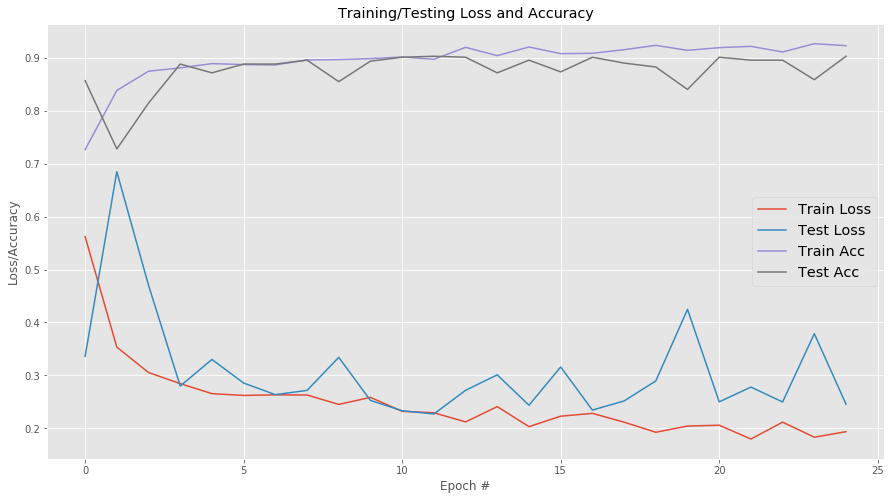

In [185]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.figure(figsize=(15,8))
plt.plot(np.arange(0, N), H.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="Test Loss")
plt.plot(np.arange(0, N), H.history["acc"], label="Train Acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="Test Acc")
plt.title("Training/Testing Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="right",fontsize='x-large')
plt.show()

As we can see, over each epoch both the training and testing losses decrease to around 0.25, while the accuracies increase to 90%.

### 4.5 Evaluation

We can now see for ourselves how acccurate the model is with some test predictions and visualizations. To run our predictions through the model, we have to load in the test images, resize and rescale them, use the model to make predictions, create the labels based on the predictions, then format our output images.

In [180]:
# load some images
test_img1 = 'projdata/test/food/v3Egaj0EuvVjDJomXSuQEg.jpg'
test_img2 = 'projdata/test/food/cXkz5Yx46bMsudTi7n9qXA.jpg'
test_img3 = 'projdata/test/outside/ycSVGgayYvm9GRhHBpG2jw.jpg'
test_img4 = 'projdata/test/outside/r6oOljrNerQ9RLVpyQgkGg.jpg'
test_paths = [test_img1, test_img2, test_img3, test_img4]
outs = []
for path in test_paths:
    # load image
    image = cv2.imread(path)
    orig = image.copy()

    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    # classify the input image
    (outside, food) = model.predict(image)[0]
    
    # build the label
    label = "Food" if food > outside else "Outside"
    proba = food if food > outside else outside
    label = "{}: {:.2f}%".format(label, proba * 100)

    # draw the label on the image
    output = imutils.resize(orig, width=400)
    cv2.putText(output, label, (10, 25),  
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    output=cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    outs.append(Image.fromarray(output))

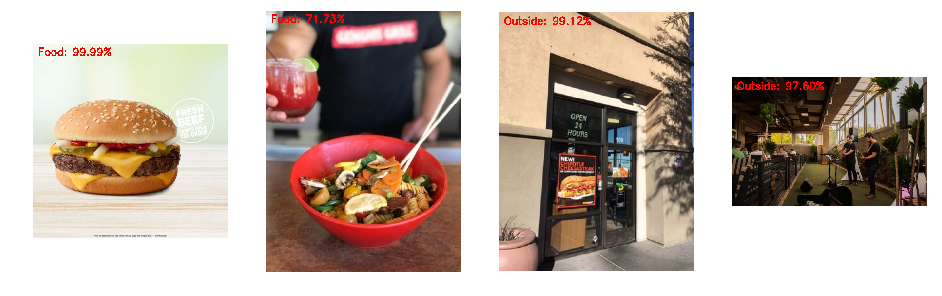

In [181]:
fig = plt.figure(figsize=(16,16))
image1 = plt.subplot(141)
image2 = plt.subplot(142)
image3 = plt.subplot(143)
image4 = plt.subplot(144)
_ = image1.imshow(outs[0])
_ = image2.imshow(outs[1])
_ = image3.imshow(outs[2])
_ = image4.imshow(outs[3])
image1.axis("off")
image2.axis("off")
image3.axis("off")
image4.axis("off")
plt.show()

As we can see, the network correctly predicts the nature of most of the images with confidence. The second image from the left was only predicted correctly with a probability of about 72%; this could likely be due to the other distracting parts of the image, like the man in the background and the drink held close to the camera. Besides this, the network is still impressively able to correctly classify the subject of each image.

## 5 Conclusion

## 6 References

* *Yelp Open Dataset* by Yelp, https://www.yelp.com/dataset
* *LeNet – Convolutional Neural Network in Python* by Adrian Rosebrock, https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/
* *Image classification with Keras and deep learning* by Adrian Rosebrock, https://www.pyimagesearch.com/2017/12/11/image-classification-with-keras-and-deep-learning/
* *Building powerful image classification models using very little data* by Francois Chollet, https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
* *Gentle Introduction to the Adam Optimization Algorithm for Deep Learning* by Jason Brownlee, https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/